In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import scipy.fft
import matplotlib.pyplot as plt

from pyinverse.phantom import Phantom
from pyinverse.axis import RegularAxis
from pyinverse.grid import RegularGrid
from pyinverse.radon import radon_matrix
from pyinverse.fbp import BackProjector

In [3]:
#Nx = 32
#Ny = 73
#Ny = 32
Nx = Ny = 64
Na = 201
Np = 1001

In [4]:
axis_x = RegularAxis.linspace(-1, 1, Nx)
axis_y = RegularAxis.linspace(-1, 1, Ny)
axis_t = RegularAxis.linspace(-3, 3, Np)
axis_theta = RegularAxis.linspace(0, 180, Na, endpoint=False)

In [5]:
print(axis_x)
print(axis_y)
print(axis_t)
print(axis_theta)

RegularAxis: -1.0 -- 1.0, N=64, T=0.031746031746031744
RegularAxis: -1.0 -- 1.0, N=64, T=0.031746031746031744
RegularAxis: -3.0 -- 3.0, N=1001, T=0.006
RegularAxis: 0.0 -- 179.1044776119403, N=201, T=0.8955223880597015


In [6]:
grid = RegularGrid(axis_x, axis_y)
grid_y = RegularGrid(axis_theta, axis_t)

In [7]:
print(grid)

RegularGrid:
axis x: RegularAxis: -1.0 -- 1.0, N=64, T=0.031746031746031744
axis y: RegularAxis: -1.0 -- 1.0, N=64, T=0.031746031746031744


In [8]:
print(grid_y)

RegularGrid:
axis x: RegularAxis: 0.0 -- 179.1044776119403, N=201, T=0.8955223880597015
axis y: RegularAxis: -3.0 -- 3.0, N=1001, T=0.006


In [9]:
R = radon_matrix(grid, grid_y, a=1/grid_y.axis_y.T)

100%|███████████████████████████████████████████████████████████| 4096/4096 [04:54<00:00, 13.91it/s]


In [10]:
p = Phantom()

In [11]:
y = p.sinogram(grid_y, rect=True, a=1/grid_y.axis_y.T)
y.shape

(1001, 201)

<IPython.core.display.Javascript object>


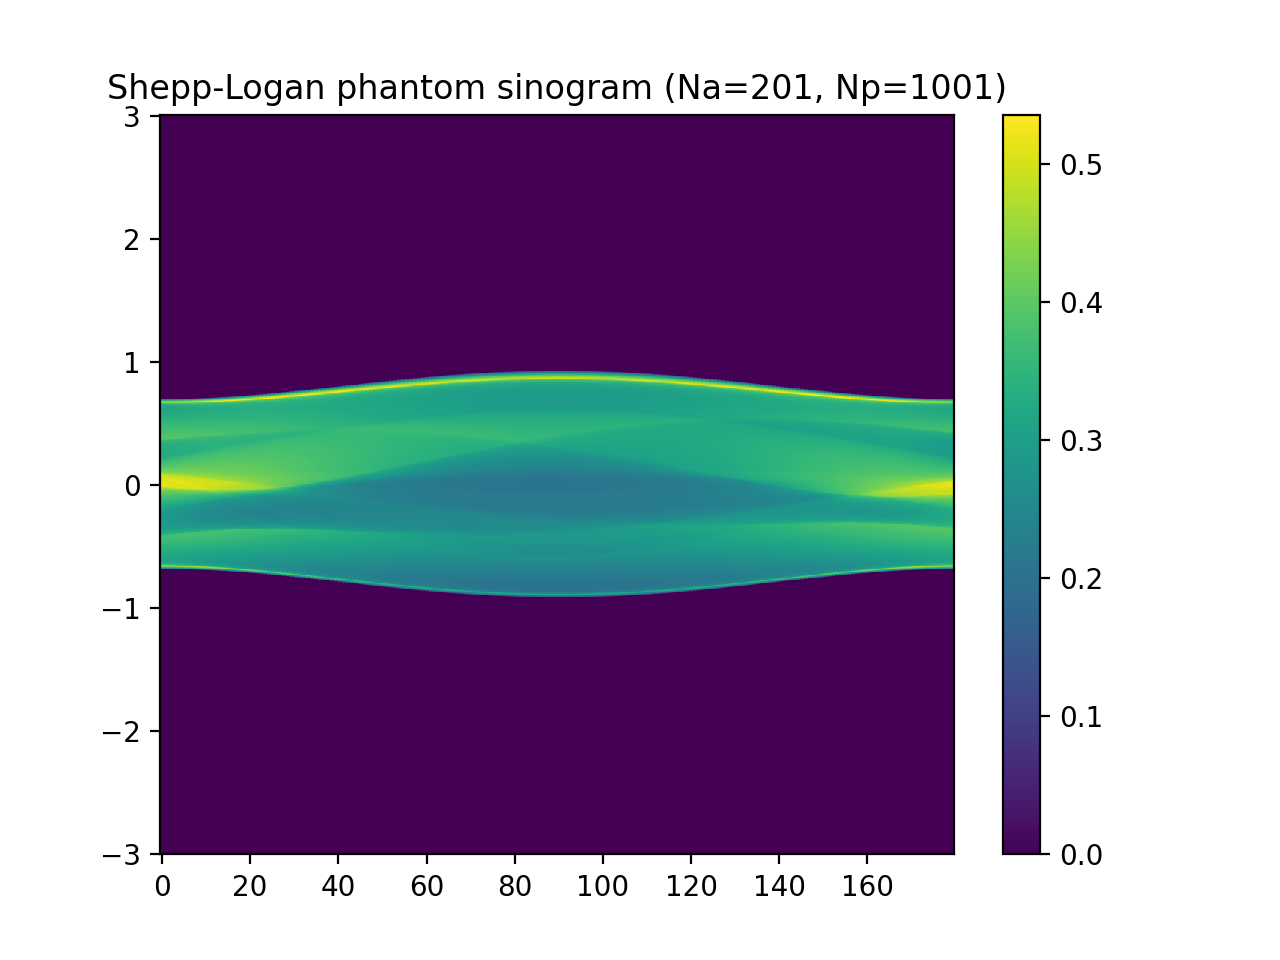

In [12]:
fig, ax = plt.subplots()
im = grid_y.plot(ax, y, aspect='auto')
fig.colorbar(im)
ax.set_title(f'Shepp-Logan phantom sinogram (Na={Na}, Np={Np})');

In [13]:
grid_y_ft = grid_y.spectrum_grid(axis=0)

In [14]:
y_ft = p.proj_ft(grid_y_ft.Hz(axis=0), rect=True, a=1/grid_y.axis_y.T)

In [15]:
grid_y_fft, y_fft = grid_y.spectrum(y, axis=0)

In [16]:
grid_y_ft

<FreqRegularGrid <axis_x: <RegularAxis x0=0 T=0.8955223880597015 N=201>> <axis_y: <FFTRegularAxis x0=-523.0756998984004 T=1.0461513997968008 N=1001>>>

In [17]:
grid_y_fft  # should be equal to grid_y_ft

<FreqRegularGrid <axis_x: <RegularAxis x0=0 T=0.8955223880597015 N=201>> <axis_y: <FFTRegularAxis x0=-523.0756998984004 T=1.0461513997968008 N=1001>>>

<IPython.core.display.Javascript object>


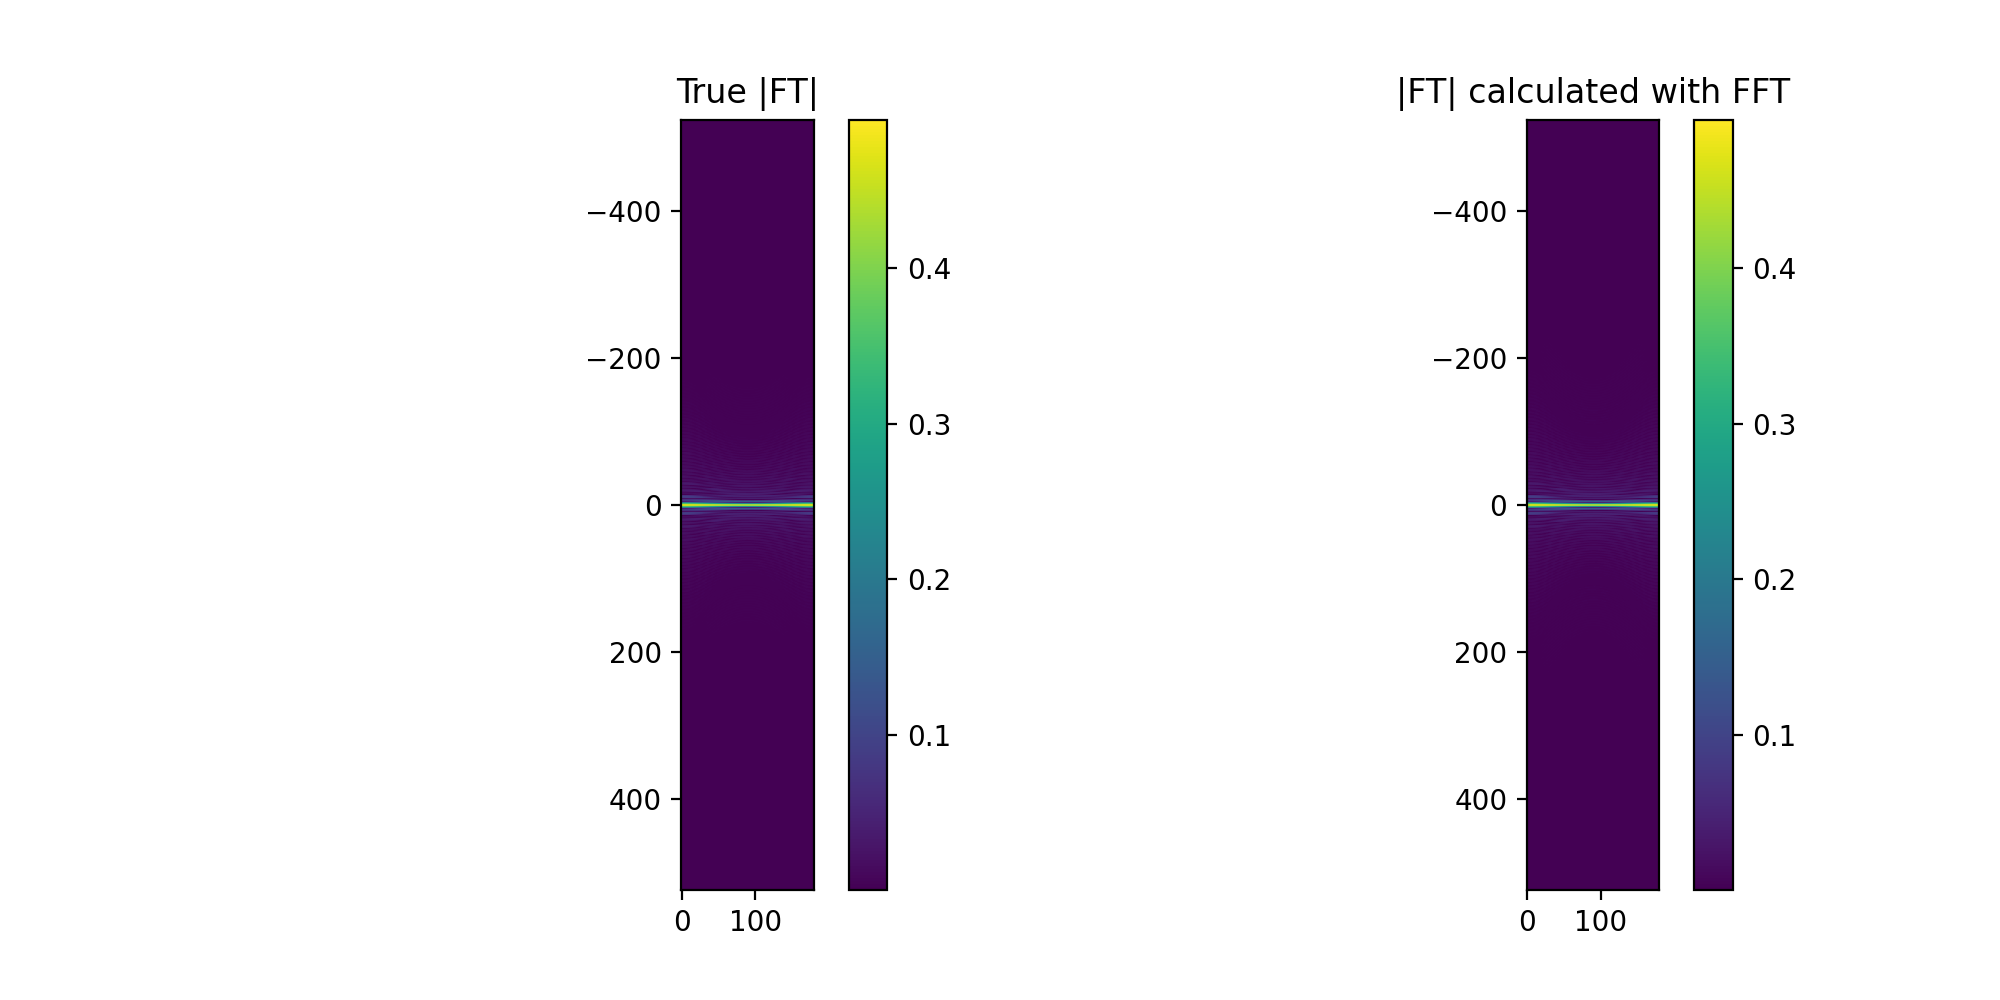

In [18]:
fig, ax = plt.subplots(figsize=(10,5), ncols=2)
im0 = grid_y_ft.plot(ax[0], np.abs(y_ft))
fig.colorbar(im0, ax=ax[0])
ax[0].set_title('True |FT|')
im1 = grid_y_fft.plot(ax[1], np.abs(y_fft))
fig.colorbar(im1, ax=ax[1])
ax[1].set_title('|FT| calculated with FFT');

In [19]:
grid_z_no_filter, z_no_filter = grid_y_ft.ispectrum(y_ft, axis=0)

In [20]:
grid_y

<RegularGrid <axis_x: <RegularAxis x0=0 T=0.8955223880597015 N=201>> <axis_y: <RegularAxis x0=-3 T=0.006 N=1001>>>

In [21]:
grid_z_no_filter  # should be the same as grid_y

<RegularGrid <axis_x: <RegularAxis x0=0 T=0.8955223880597015 N=201>> <axis_y: <RegularAxis x0=-3 T=0.006 N=1001>>>

In [22]:
assert np.allclose(np.imag(z_no_filter), 0)
z_no_filter = np.real(z_no_filter)

<IPython.core.display.Javascript object>


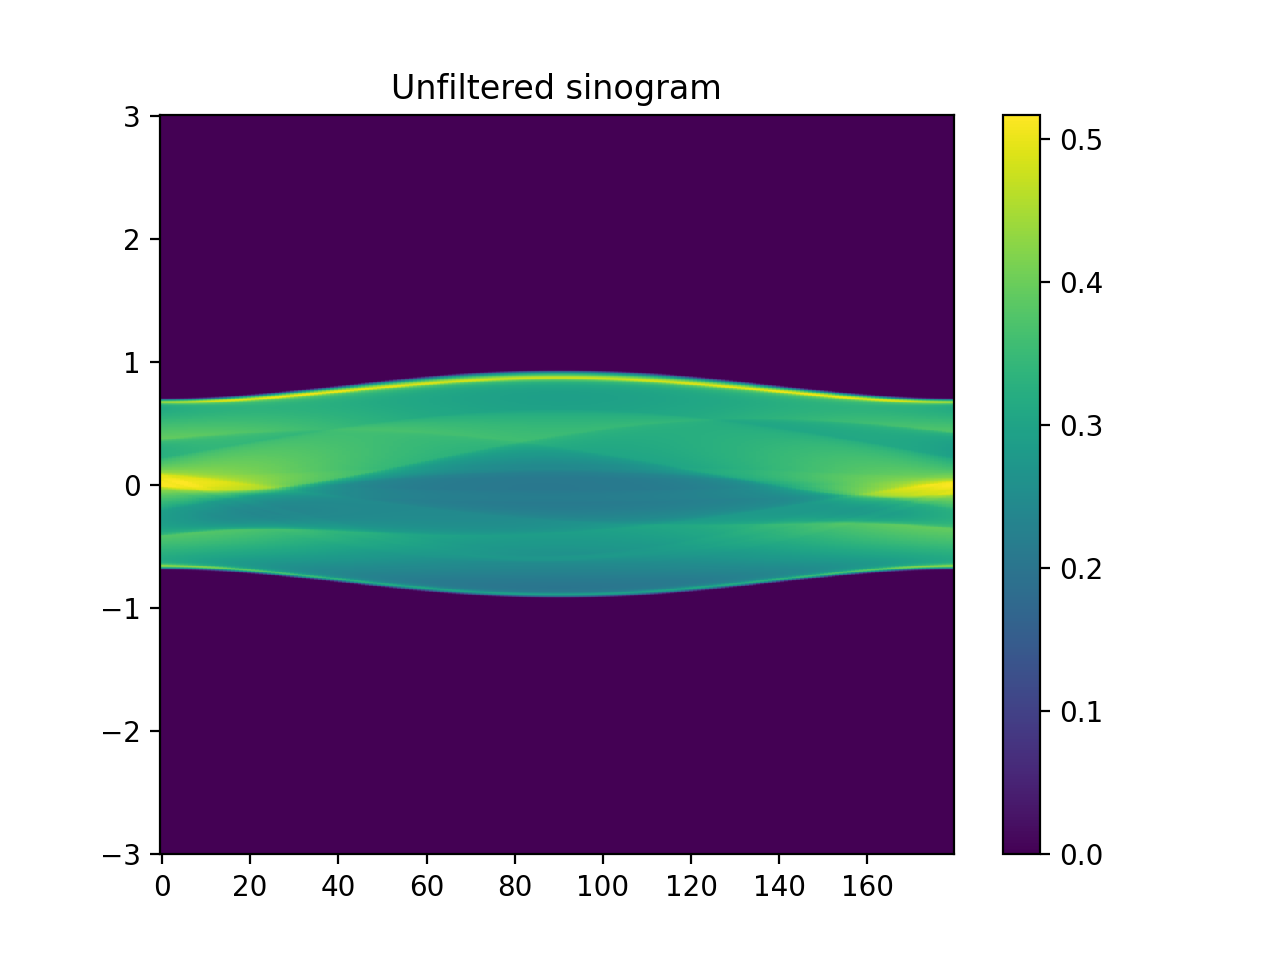

In [23]:
fig, ax = plt.subplots()
im = grid_z_no_filter.plot(ax, z_no_filter, aspect='auto')
fig.colorbar(im)
ax.set_title(f'Unfiltered sinogram');

In [24]:
bp = BackProjector(grid, grid_y, radon_matrix=R)

In [25]:
x_bp = bp @ z_no_filter.flat
x_bp.shape = Ny, Nx

In [26]:
x_bp.shape

(64, 64)

In [27]:
grid

<RegularGrid <axis_x: <RegularAxis x0=-1 T=0.031746031746031744 N=64>> <axis_y: <RegularAxis x0=-1 T=0.031746031746031744 N=64>>>

<IPython.core.display.Javascript object>


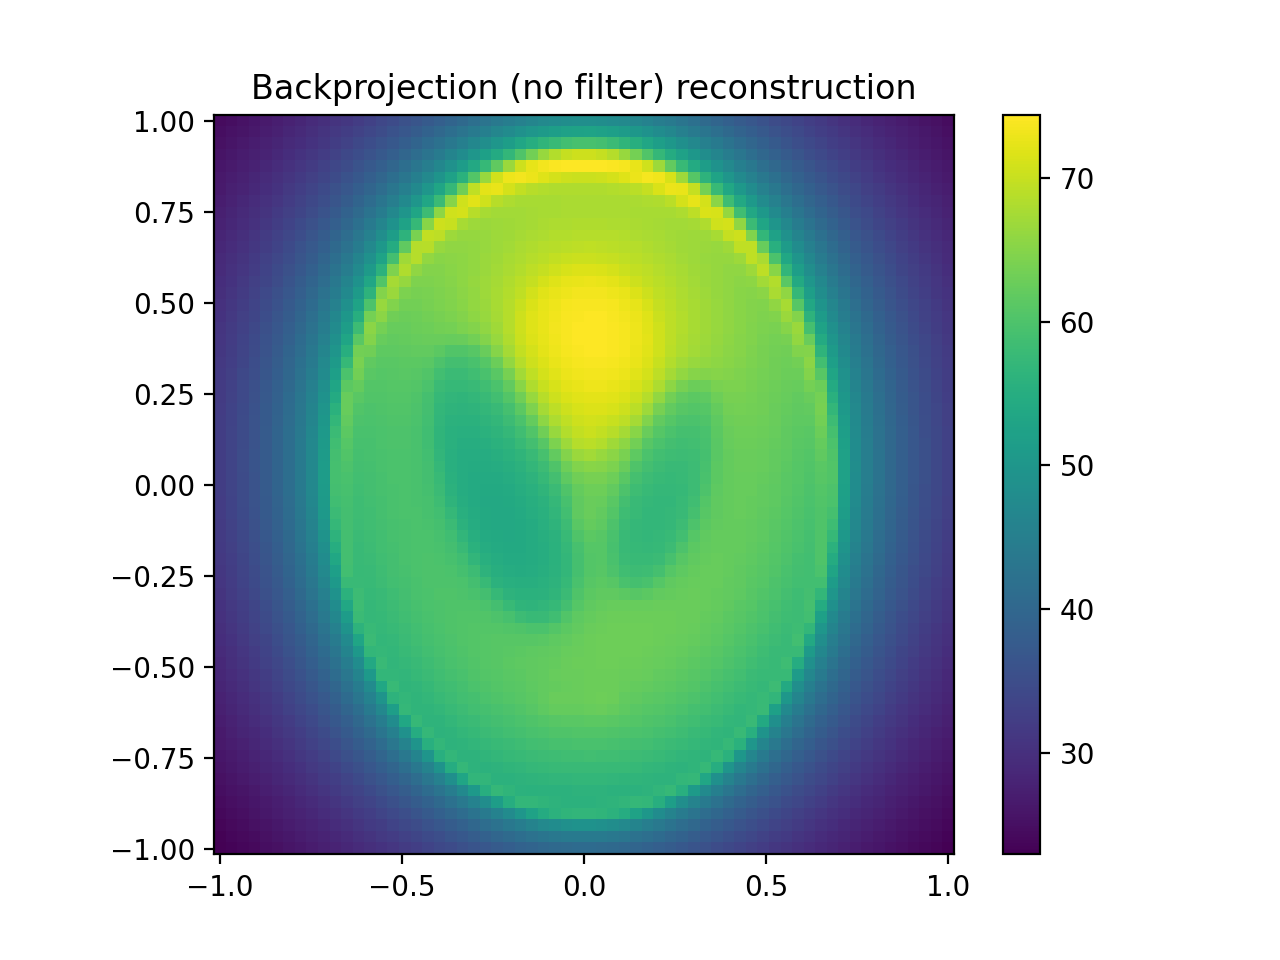

In [28]:
fig, ax = plt.subplots()
im = grid.plot(ax, x_bp)
fig.colorbar(im)
ax.set_title('Backprojection (no filter) reconstruction');

In [29]:
W = np.abs(grid_y_ft.axis_y.centers / (2 * np.pi)) # W(f) = |f|

In [30]:
grid_y.axis_y

<RegularAxis x0=-3 T=0.006 N=1001>

<IPython.core.display.Javascript object>


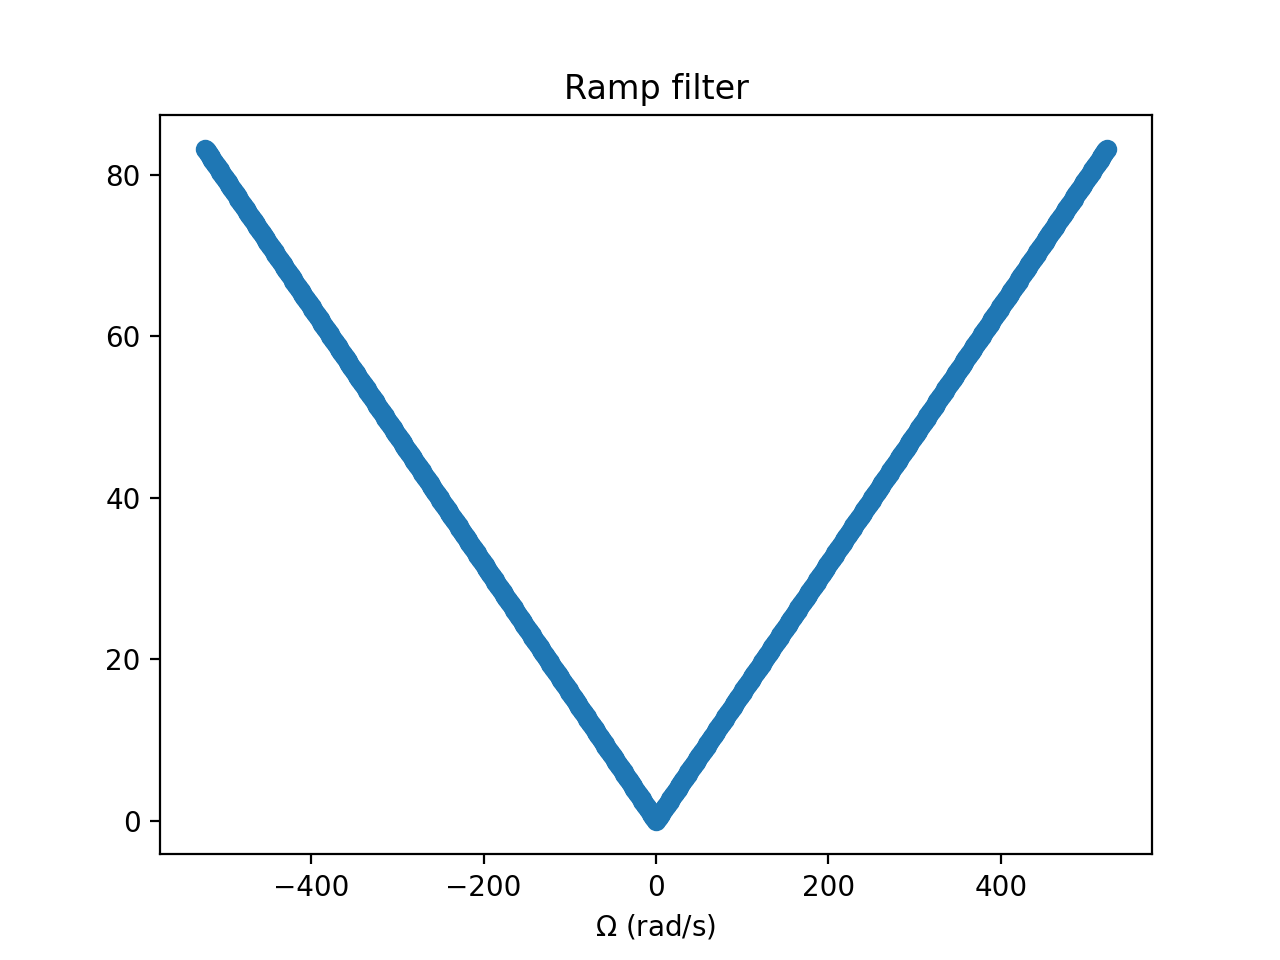

In [31]:
fig, ax = plt.subplots()
plt.scatter(grid_y_ft.axis_y.centers, W)
ax.set_xlabel(r'$\Omega$ (rad/s)')
ax.set_title('Ramp filter');

In [32]:
grid_z_filter, z_filter = grid_y_ft.ispectrum(np.atleast_2d(W).T * y_ft, axis=0)

In [33]:
grid_y

<RegularGrid <axis_x: <RegularAxis x0=0 T=0.8955223880597015 N=201>> <axis_y: <RegularAxis x0=-3 T=0.006 N=1001>>>

In [34]:
grid_z_filter  # should be equal to grid_y

<RegularGrid <axis_x: <RegularAxis x0=0 T=0.8955223880597015 N=201>> <axis_y: <RegularAxis x0=-3 T=0.006 N=1001>>>

In [35]:
assert np.allclose(np.imag(z_filter), 0)
z_filter = np.real(z_filter)

In [36]:
z_filter.shape

(1001, 201)

<IPython.core.display.Javascript object>


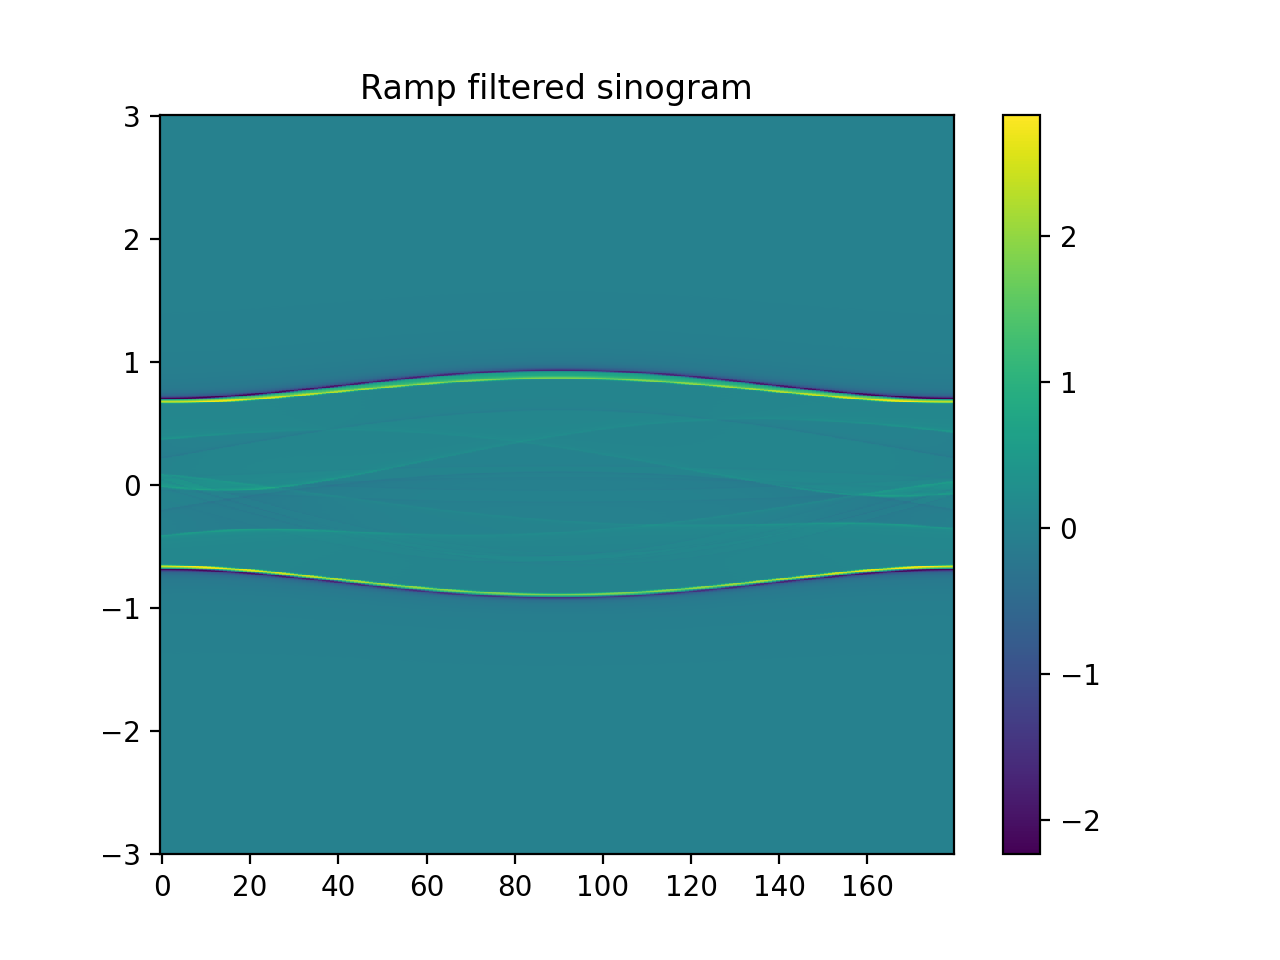

In [37]:
fig, ax = plt.subplots()
im = grid_z_filter.plot(ax, z_filter, aspect='auto')
fig.colorbar(im)
ax.set_title(f'Ramp filtered sinogram');

In [38]:
x_fbp = (bp @ z_filter.flat) * np.radians(grid_y.axis_x.T) 
x_fbp.shape = Ny, Nx

<IPython.core.display.Javascript object>


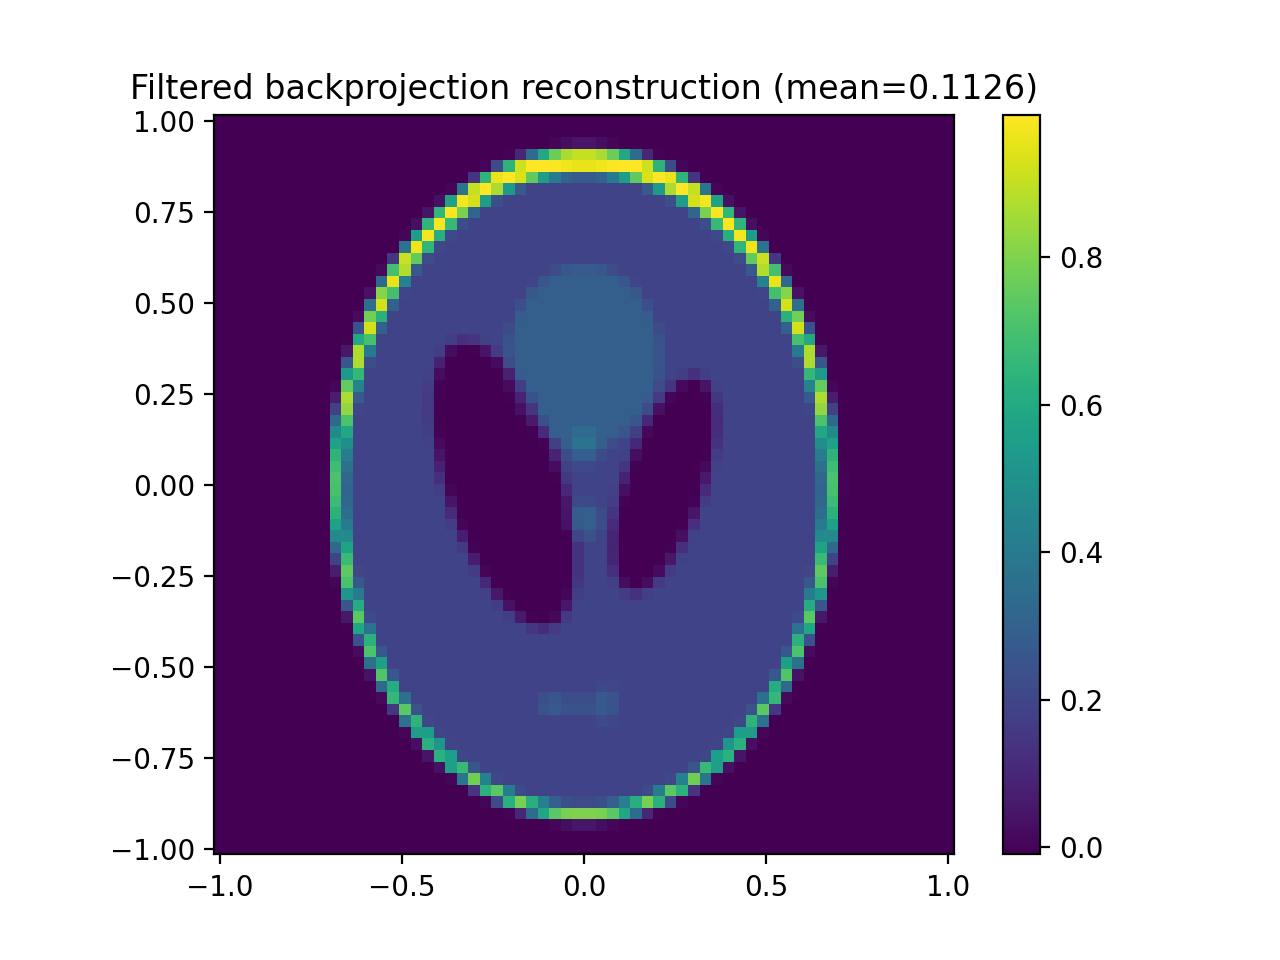

In [39]:
fig, ax = plt.subplots()
im = grid.plot(ax, x_fbp)
fig.colorbar(im)
ax.set_title(f'Filtered backprojection reconstruction (mean={np.mean(x_fbp):.4f})');

In [40]:
np.mean(x_fbp)

0.11255103105310853

In [41]:
x_true = p.raster(grid)

In [42]:
np.mean(x_true)

0.11992565917968737

<IPython.core.display.Javascript object>


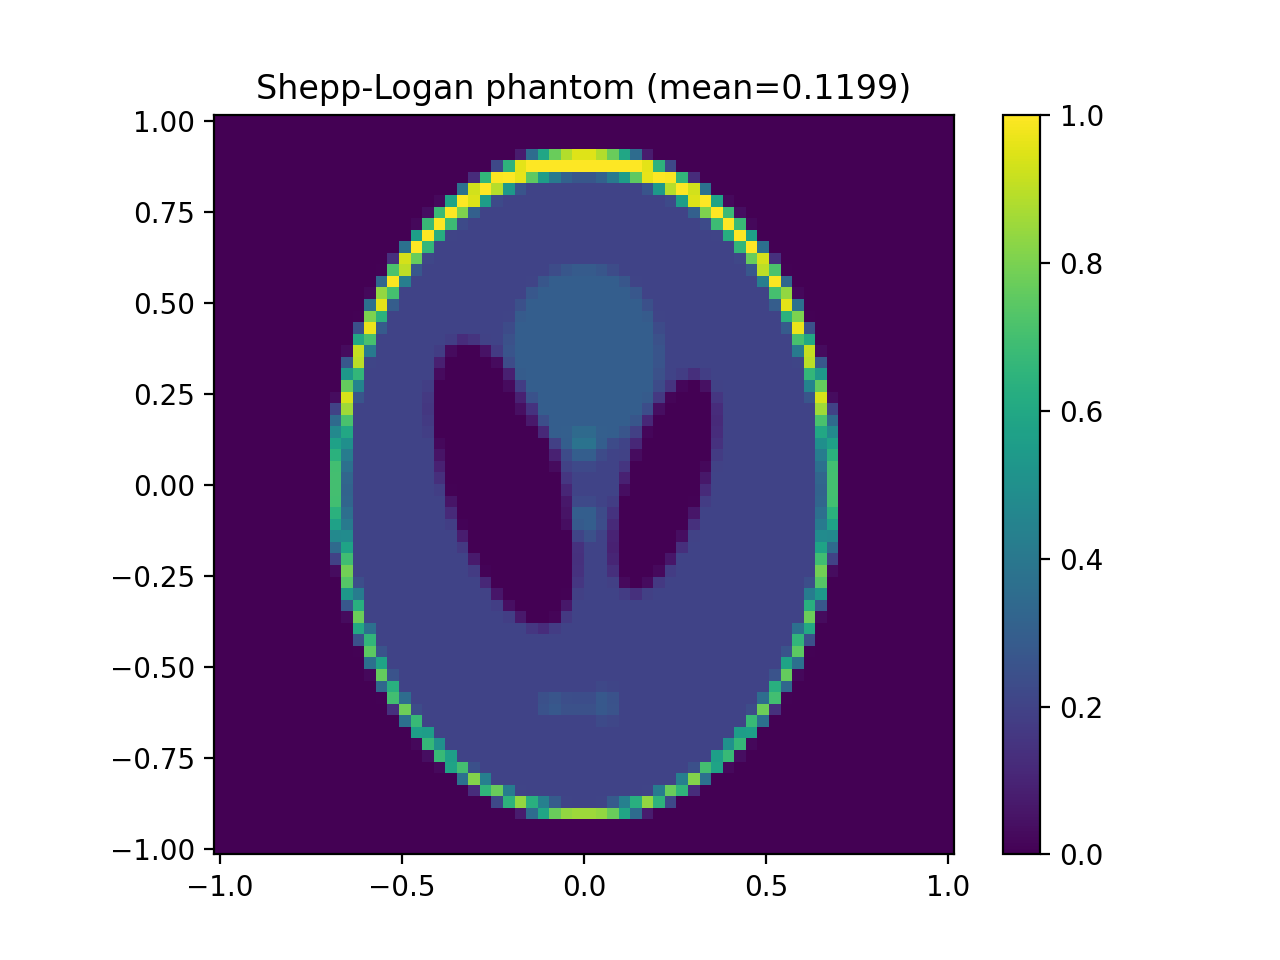

In [43]:
fig, ax = plt.subplots()
im = grid.plot(ax, x_true)
fig.colorbar(im)
ax.set_title(f'Shepp-Logan phantom (mean={np.mean(x_true):.4f})');

In [44]:
y_radon_matrix = R @ x_true.flat
y_radon_matrix.shape = grid_y.shape

<IPython.core.display.Javascript object>


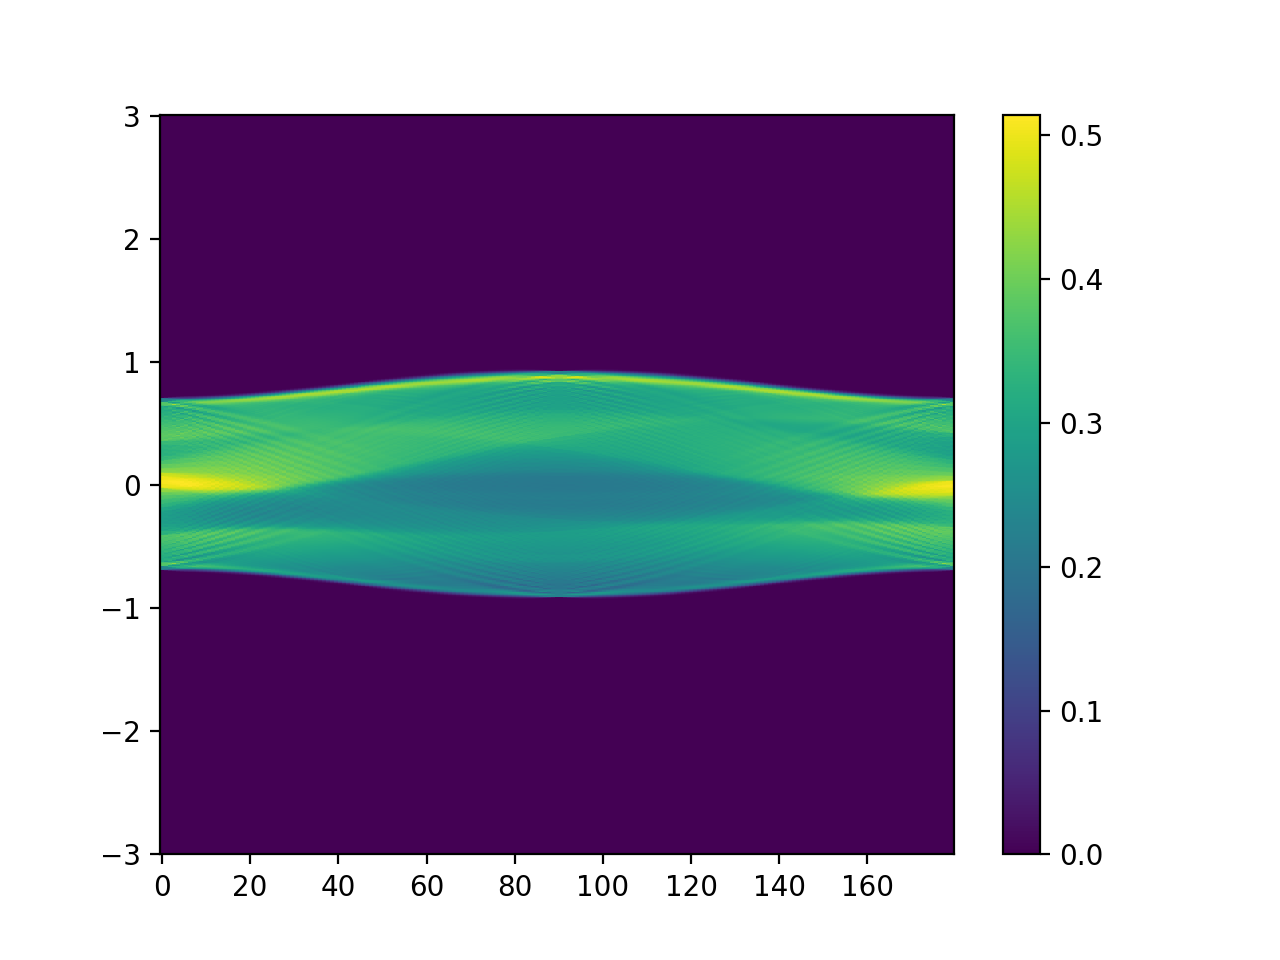

In [45]:
fig, ax = plt.subplots()
im = grid_y.plot(ax, y_radon_matrix, aspect='auto')
fig.colorbar(im, ax=ax);

In [46]:
from pyinverse.fbp import fbp

In [47]:
x_fbp2 = fbp(grid, grid_y, z_no_filter, radon_matrix=R)
#x_fbp2 = fbp(grid, grid_y, y, radon_matrix=R)
#x_fbp2 = fbp(grid, grid_y, y)

<IPython.core.display.Javascript object>


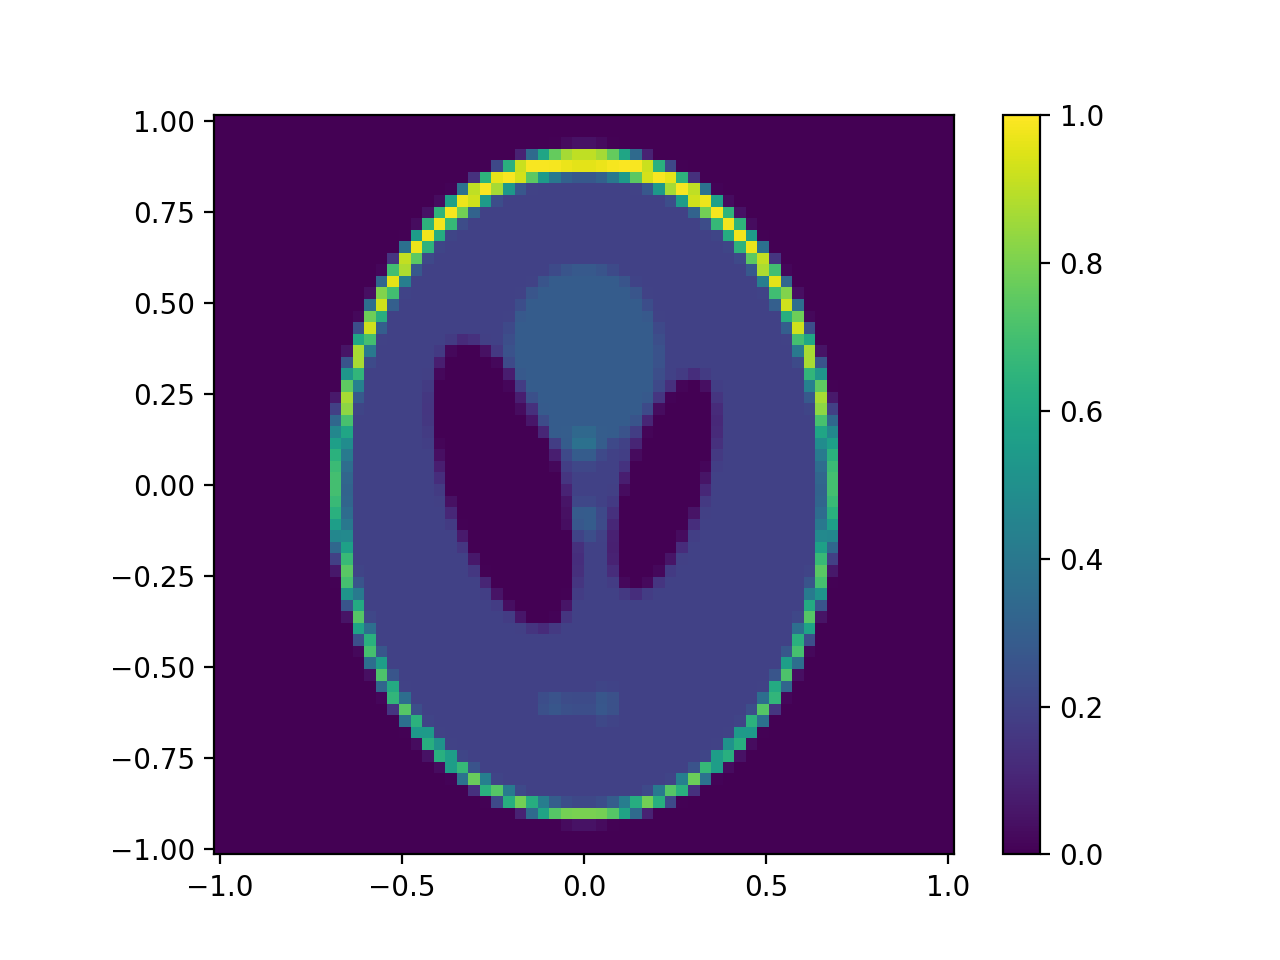

In [48]:
fig, ax = plt.subplots()
im = grid.plot(ax, x_fbp2, vmin=0, vmax=1)
fig.colorbar(im, ax=ax)